# Imports

In [ ]:
# pip install pandas numpy seaborn scipy sklearn scikit-plot sweetviz matplotlib
# xgboost boruta


In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection   as ms
from sklearn import ensemble          as en

import scikitplot as skplt
import sweetviz as sv

from matplotlib import pyplot as plt
import xgboost

from boruta import BorutaPy

# Load Data

## Helper Functions

In [4]:
df_raw = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [5]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

# Data Description

In [6]:
df1 = df_raw.copy()

df1.shape

(11762, 14)

## Dtypes

In [7]:
df1.dtypes

country                   object
year                       int64
uniqueid                  object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
uid                       object
bank_account              object
dtype: object

In [8]:
df1.sample().T

,11724
country,Rwanda
year,2016
uniqueid,uniqueid_5327
location_type,Rural
cellphone_access,Yes
household_size,5
age_of_respondent,29
gender_of_respondent,Male
relationship_with_head,Head of Household
marital_status,Married/Living together


## Check NA

In [9]:
df1.isna().sum()

country                   0
year                      0
uniqueid                  0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
uid                       0
bank_account              0
dtype: int64

## Change types

In [10]:
df1['bank_account'] = df1['bank_account'].apply(lambda x: 1 if x=='Yes' else 0)

# Estatísticas descritiva

In [11]:
num_attributes = df1.select_dtypes(['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

In [12]:
num_attributes.describe()

,year,household_size,age_of_respondent,bank_account
count,11762.000000,11762.000000,11762.000000,11762.000000
mean,2016.983336,3.793913,38.602364,0.143258
std,0.848669,2.225423,16.334624,0.350351
min,2016.000000,1.000000,16.000000,0.000000
25%,2016.000000,2.000000,26.000000,0.000000
50%,2017.000000,3.000000,35.000000,0.000000
75%,2018.000000,5.000000,48.000000,0.000000
max,2018.000000,21.000000,100.000000,1.000000


In [13]:
cat_attributes.describe()

,country,uniqueid,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid
count,11762,11762,11762,11762,11762,11762,11762,11762,11762,11762
unique,4,6916,2,2,2,6,5,6,10,11762
top,Rwanda,uniqueid_403,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Self employed,Rwanda_uniqueid_4858
freq,4335,4,7100,8786,6902,6358,5433,6408,3207,1


In [14]:
df1['bank_account'].value_counts(normalize=True)

0    0.856742
1    0.143258
Name: bank_account, dtype: float64

In [15]:
df1['country'].value_counts(normalize=True)

Rwanda      0.368560
Tanzania    0.279544
Kenya       0.259480
Uganda      0.092416
Name: country, dtype: float64

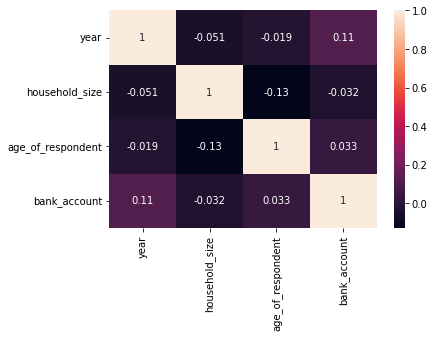

In [20]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [125]:
# #List os cat attributes for cramer v correlation
# cat_attributes_list = cat_attributes.columns.tolist()

# #dict to get all corr (rowxcolumn)
# corr_dict = {}
# for i in range(len(cat_attributes_list)):
#     corr_list=[]
#     for j in range(len(cat_attributes_list)):
#         ref = cat_attributes_list[i]
#         feat = cat_attributes_list[j]
        
#         corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
#         corr_list.append(corr)
#     corr_dict[ref] = corr_list

# corr_df = pd.DataFrame(corr_dict)
# corr_df = corr_df.set_index(corr_df.columns)

# sns.heatmap(corr_df, annot=True);

### EDA Sweet Viz

In [126]:
my_report = sv.analyze(df1, target_feat='bank_account')

my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

                                             |      | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### insights

* Cellphone access é muito decisivo para variavel resposta
* Quênia possui maior proporção de pessoas com conta bancária (26%)
* Ruanda possui maior número absoluto, mas proporcionalmente é baixo
* O ano parece não ser muito relevante (avaliar...)
* 60% da amostra está na área rural, e a proporção destes com conta bancária é inferior àqueles da zona urbana
* O uso de banco decai para idades avançadas
* Homens utilizam mais o serviço proporcionalmente
* Quanto maior o nivel educacional, maior proporção de pessoas que usam serviço

* Investigar outliers em relação ao household size

* marital status pouco relevante

### para o próximo ciclo

* analisar a correlação entre grau de educação com tipo de emprego, remover caso haja multicolinearidade


## Feature Engineering

In [127]:
#classificar tipo de trabalhos e agrupar - Emprego fixo (1,0)
#classificar idades 
#classificar relationship with head - provedor (1,0)



#remover "Dont know" - marital status
#remover "Other/Dont know/RTA" - education level
#remover 'Dont Know/Refuse to answer' - job 


In [128]:
df2 = df1.copy()

In [129]:
df2.sample().T

,9787
country,Rwanda
year,2016
uniqueid,uniqueid_4918
location_type,Rural
cellphone_access,Yes
household_size,2
age_of_respondent,68
gender_of_respondent,Female
relationship_with_head,Head of Household
marital_status,Widowed


In [130]:
#location type & cellphone
df2['rural_cellphone_access'] = df2.apply(lambda x: 1 if (x['location_type']=='Rural') & (x['cellphone_access']=='Yes') else 0, axis=1)
df2['urban_cellphone_access'] = df2.apply(lambda x: 1 if (x['location_type']=='Urban') & (x['cellphone_access']=='Yes') else 0, axis=1)

#Classificar idades 
df2['idade_categoria'] = df2['age_of_respondent'].apply(lambda x: 'jovem' if x<20 else
                                                        'jovem_adulto' if (x>=20) & (x<30) else
                                                        'adulto' if (x>=30) & (x<40) else
                                                        'meia_idade' if (x>=40) & (x<55) else 
                                                         'idosos')

#classificar relationship with head

df2['provedor'] = df2['relationship_with_head'].apply(lambda x: 1 if (x=='Head of Household') or (x=='Spouse') else 0)





Cada uniqueid pode ter até 4 pessoas (uid) diferentes de países diferentes cadastradas.

In [131]:
# my_report = sv.analyze(df2, target_feat='bank_account')

# my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

                                             |      | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# EDA

## Bivariate Analysis

### cellphone access 

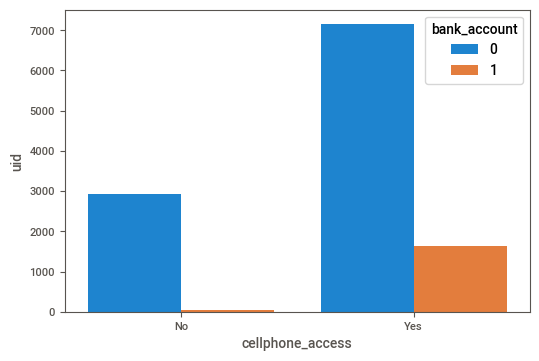

In [173]:

aux = df2[['cellphone_access', 'uid', 'bank_account']].groupby(['cellphone_access', 'bank_account']).count().reset_index()

sns.barplot(data= aux, x='cellphone_access', y='uid', hue='bank_account');

### job type

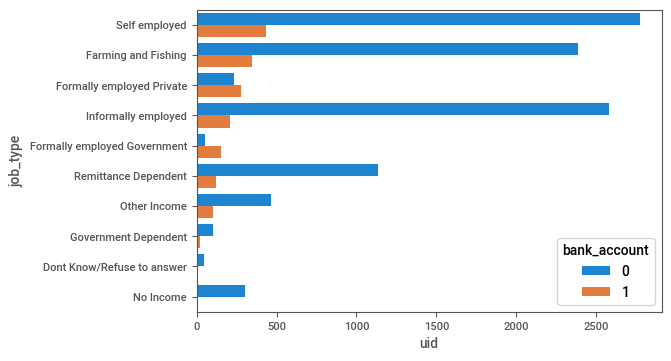

In [178]:
aux = df2[['job_type', 'uid', 'bank_account']].groupby(['job_type', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)

sns.barplot(data= aux, x='uid', y='job_type', hue='bank_account');

### marital status

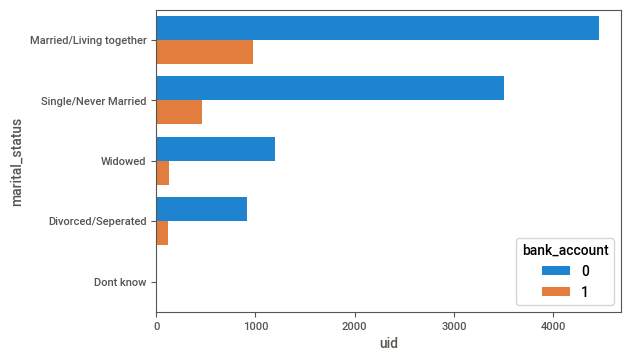

In [179]:
aux = df2[['marital_status', 'uid', 'bank_account']].groupby(['marital_status', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)

sns.barplot(data= aux, x='uid', y='marital_status', hue='bank_account');

### country gender

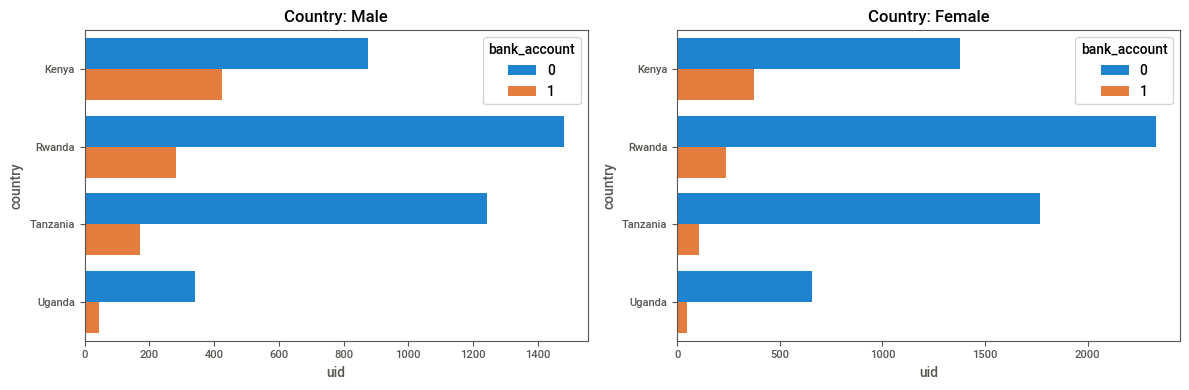

In [199]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)

male = df2[df2['gender_of_respondent']=='Male']
female = df2[df2['gender_of_respondent']=='Female']


aux = male[['country', 'uid', 'bank_account']].groupby(['country', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)
aux1 = female[['country', 'uid', 'bank_account']].groupby(['country', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)

sns.barplot(data= aux, x='uid', y='country', hue='bank_account').set_title('Country: Male');

plt.subplot(1,2,2)

sns.barplot(data= aux1, x='uid', y='country', hue='bank_account').set_title('Country: Female');

plt.tight_layout()

### gender and marital status

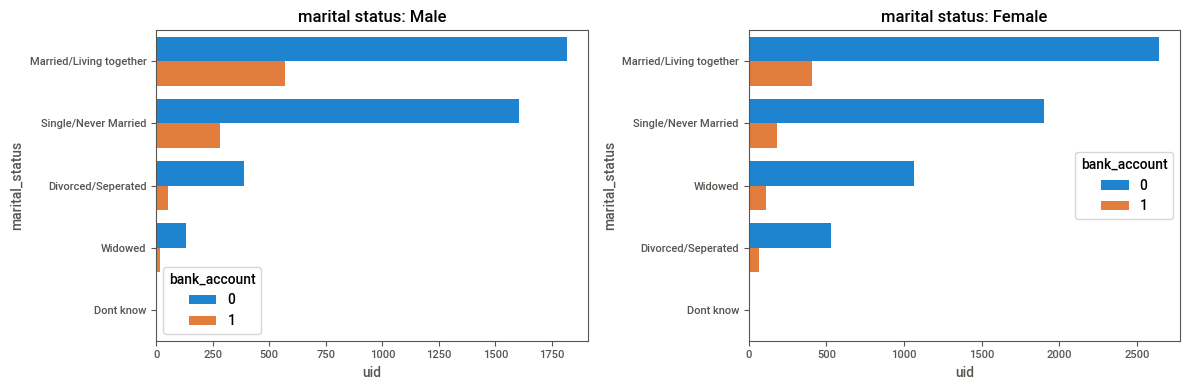

In [200]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)

male = df2[df2['gender_of_respondent']=='Male']
female = df2[df2['gender_of_respondent']=='Female']


aux = male[['marital_status', 'uid', 'bank_account']].groupby(['marital_status', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)
aux1 = female[['marital_status', 'uid', 'bank_account']].groupby(['marital_status', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)

sns.barplot(data= aux, x='uid', y='marital_status', hue='bank_account').set_title('marital status: Male');

plt.subplot(1,2,2)

sns.barplot(data= aux1, x='uid', y='marital_status', hue='bank_account').set_title('marital status: Female');

plt.tight_layout()

### gender e job type

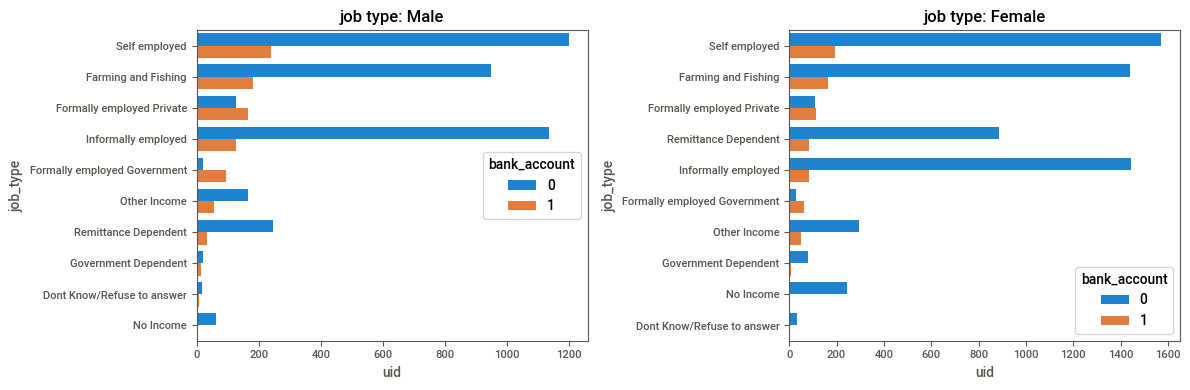

In [205]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)

male = df2[df2['gender_of_respondent']=='Male']
female = df2[df2['gender_of_respondent']=='Female']


aux = male[['job_type', 'uid', 'bank_account']].groupby(['job_type', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)
aux1 = female[['job_type', 'uid', 'bank_account']].groupby(['job_type', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)

sns.barplot(data= aux, x='uid', y='job_type', hue='bank_account').set_title('job type: Male');

plt.subplot(1,2,2)

sns.barplot(data= aux1, x='uid', y='job_type', hue='bank_account').set_title('job type: Female');

plt.tight_layout()

Formally employed Private é a classe com maior proporção de pessoas que usam o serviço

### gender e age

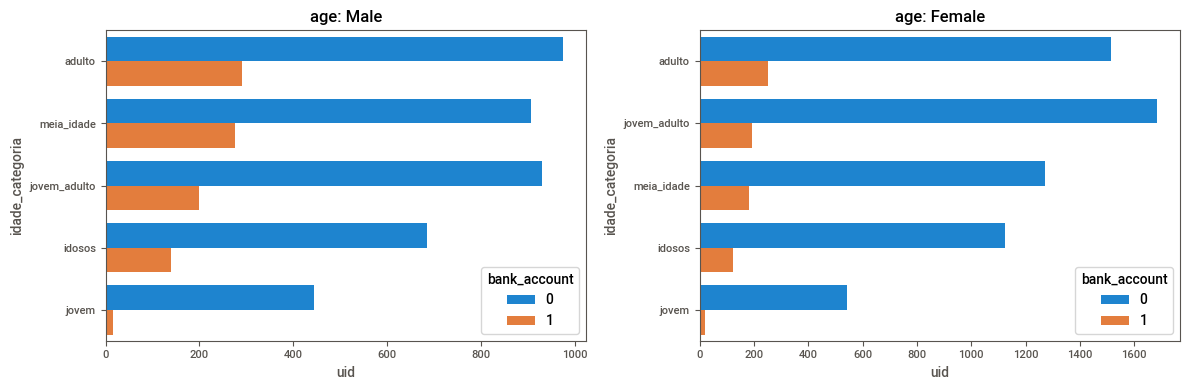

In [206]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)

male = df2[df2['gender_of_respondent']=='Male']
female = df2[df2['gender_of_respondent']=='Female']


aux = male[['idade_categoria', 'uid', 'bank_account']].groupby(['idade_categoria', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)
aux1 = female[['idade_categoria', 'uid', 'bank_account']].groupby(['idade_categoria', 'bank_account']).count().reset_index().sort_values(['bank_account','uid'], ascending=False)

sns.barplot(data= aux, x='uid', y='idade_categoria', hue='bank_account').set_title('age: Male');

plt.subplot(1,2,2)

sns.barplot(data= aux1, x='uid', y='idade_categoria', hue='bank_account').set_title('age: Female');

plt.tight_layout()

### Split train e validation

In [133]:
X = df2.drop(['uid', 'uniqueid', 'bank_account', 'idade_categoria'], axis=1)
y = df2['bank_account'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2)

# Data preparation

In [134]:
df3 = pd.concat([X_train, y_train], axis=1)
df3

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,rural_cellphone_access,urban_cellphone_access,provedor,bank_account
3570,Rwanda,2016,Rural,Yes,7,73,Female,Head of Household,Widowed,Primary education,Farming and Fishing,1,0,1,0
9268,Kenya,2018,Urban,Yes,2,30,Female,Spouse,Married/Living together,Secondary education,Self employed,0,1,1,1
2726,Rwanda,2016,Rural,Yes,4,17,Male,Child,Single/Never Married,Secondary education,Farming and Fishing,1,0,0,0
1181,Rwanda,2016,Rural,Yes,6,35,Female,Parent,Single/Never Married,Secondary education,Formally employed Private,1,0,0,1
3115,Kenya,2018,Urban,Yes,6,29,Female,Spouse,Married/Living together,Primary education,Informally employed,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,Kenya,2018,Urban,Yes,1,24,Male,Head of Household,Married/Living together,Primary education,Informally employed,0,1,1,0
6369,Kenya,2018,Rural,Yes,10,45,Male,Head of Household,Married/Living together,Primary education,Farming and Fishing,1,0,1,0
11348,Tanzania,2017,Urban,No,2,47,Male,Spouse,Single/Never Married,Primary education,Self employed,0,0,1,0
9041,Tanzania,2017,Rural,Yes,2,33,Female,Spouse,Single/Never Married,Primary education,Remittance Dependent,1,0,1,0


In [135]:
mms = pp.MinMaxScaler()

### Rescala

In [136]:
df3['year'] = mms.fit_transform(df3[['year']])
df3['household_size'] = mms.fit_transform(df3[['household_size']])
df3['age_of_respondent'] = mms.fit_transform(df3[['age_of_respondent']])


### Encoding 

In [137]:
df3 = pd.get_dummies(df3, prefix='gender', columns=['gender_of_respondent'])

df3 = pd.get_dummies(df3, prefix='location_type', columns=['location_type'])

In [138]:
#frequency, target, onehot, label


#location type (OHE) 

# df3 = pd.get_dummies(df3, prefix='location_type', columns=['location_type'])

#cellphone access (1,0)

df3['cellphone_access'] = df3['cellphone_access'].apply(lambda x: 1 if x=='Yes' else 0)

#gender (OHE)

# df3 = pd.get_dummies(df3, prefix='gender', columns=['gender_of_respondent'])


#country  -- 

target_encode_country = df3.groupby('country')['bank_account'].mean()
df3.loc[:,'country'] = df3['country'].map(target_encode_country)


#relationship_with_head

target_encode_relationship_with_head = df3.groupby('relationship_with_head')['bank_account'].mean()
df3.loc[:,'relationship_with_head'] = df3['relationship_with_head'].map(target_encode_relationship_with_head)


#marital_status

target_encode_marital_status = df3.groupby('marital_status')['bank_account'].mean()
df3.loc[:,'marital_status'] = df3['marital_status'].map(target_encode_marital_status)


#education_level

target_encode_education_level = df3.groupby('education_level')['bank_account'].mean()
df3.loc[:,'education_level'] = df3['education_level'].map(target_encode_education_level)

#job_type

target_encode_job_type = df3.groupby('job_type')['bank_account'].mean()
df3.loc[:,'job_type'] = df3['job_type'].map(target_encode_job_type)

In [139]:
X = df3.drop(['bank_account'], axis=1)
y = df3['bank_account'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2)

# Feature Selection

## Extra Trees Classifier

In [140]:
df4 = df3.copy()
X_train_n = X_train.values
y_train_n = y_train.values

Feature ranking:
                  feature  importance
0       age_of_respondent    0.312673
0                job_type    0.170288
0          household_size    0.145243
0         education_level    0.140161
0          marital_status    0.044809
0                 country    0.041133
0  relationship_with_head    0.030517
0        cellphone_access    0.024885
0                    year    0.020011
0  urban_cellphone_access    0.015831
0                provedor    0.015144
0             gender_Male    0.010353
0           gender_Female    0.009534
0  rural_cellphone_access    0.007592
0     location_type_Rural    0.006154
0     location_type_Urban    0.005672


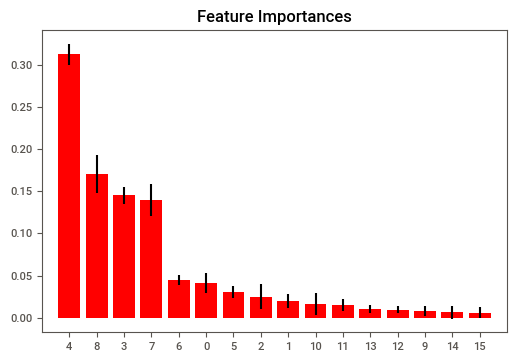

In [141]:
#model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=3, n_jobs=-1)


#data preparation
X_train_n = X_train
y_train_n = y_train.values
forest.fit(X_train_n, y_train_n)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(X_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance': j},index=[0])
    df = pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance', ascending=False))

#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train_n.shape[1]),importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train_n.shape[1]),indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show();

In [143]:
cols_selected = ['age_of_respondent',
'job_type',
'household_size',
'education_level',
                 'country',
'relationship_with_head',
'cellphone_access']



In [164]:

#training and test dataset for Boruta
#removing date and sales of train variables
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = en.RandomForestRegressor(n_jobs=-1)
#define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=41).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	5
Iteration: 	17 / 

In [166]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns , cols_selected_boruta))

In [167]:
cols_selected_boruta

['age_of_respondent', 'job_type']

In [144]:
X_train = X_train[cols_selected]
X_val = X_val[cols_selected]


# Modelo de ML

## Random Forest Classifier

In [145]:
#model definition
rf_model = en.RandomForestClassifier()

#model training
rf_model.fit(X_train, y_train)

#model predict
yhat_rf = rf_model.predict(X_val)

#metricas
metrics.f1_score(y_val, yhat_rf)

0.4421487603305785

In [146]:
metrics.accuracy_score(y_val, yhat_rf)

0.8565356004250797

In [147]:
metrics.balanced_accuracy_score(y_val, yhat_rf)

0.6619881462487488

In [148]:
metrics.recall_score(y_val, yhat_rf)

0.3862815884476534

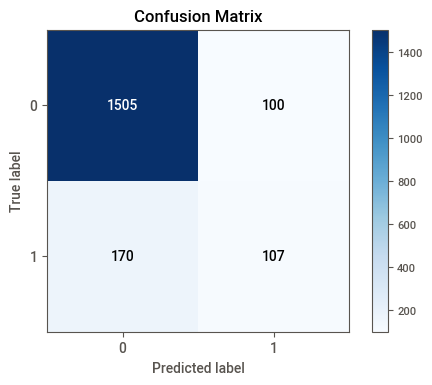

In [149]:
skplt.metrics.plot_confusion_matrix(y_val, yhat_rf);

## XGBoost

In [150]:
#model definition
xgb_model = xgboost.XGBClassifier()
#model training
xgb_model.fit(X_train, y_train)

#model predict
yhat_xgb = xgb_model.predict(X_val)

#metricas
metrics.f1_score(y_val, yhat_xgb)

0.48387096774193555

In [151]:
metrics.accuracy_score(y_val, yhat_xgb)

0.8809776833156217

In [152]:
metrics.balanced_accuracy_score(y_val, yhat_xgb)

0.6733313089735371

In [153]:
metrics.recall_score(y_val, yhat_xgb)

0.37906137184115524

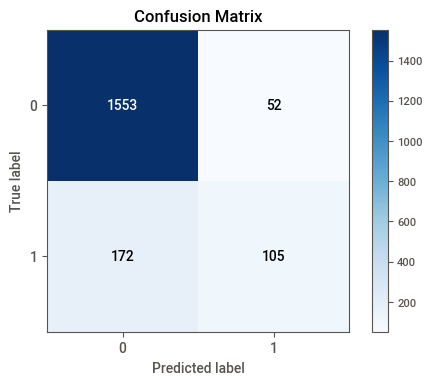

In [154]:
skplt.metrics.plot_confusion_matrix(y_val, yhat_xgb);

In [155]:
#balanceamento

#feature selection - boruta, extra trees, rankd

#eda mais profunda